<a href="https://colab.research.google.com/github/HumaSatti/Depression-Detection-By-ML-Deep-Learning-Model/blob/main/Encrypted_deep_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nurse-stress-prediction-wearable-sensors:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4110234%2F7125235%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240725%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240725T145000Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2ee34cfa641500f3842996d16fbca454a622657907a29529065f9e47768990e9900410f18b57ff0ec334c8407f80e9f08235ab016ab1128e9bfa036b38d685ffdad088f3670c47ac3fef2724b717253499683b85ed51607651d2af71f81e458af03db7d0c55f9cff695230e45070712f616caccd974f982fa6c1b77c9b52bc5e7f00d109907de0a4b3751ab214ec8b53d1529e7406ab015bcb0177bf800249d6728bbb0d43d72591d3e0fdebae6f171d1a784840e1822c78f2ed9c480acde1a3497df39ac54315953cc2af4631b043c93c0a2aada4d1a5555e63b6d3fdd551cc541dafad2f9eaf20435d1ac5d03fc107b800a4ce5ca71fac798f8acfe9b96e7f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79877492 bytes downloaded
Downloaded and uncompressed: nurse-stress-prediction-wearable-sensors
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv


In [3]:
!pip install cryptography

In [4]:

from cryptography.fernet import Fernet
import base64

In [5]:
# Generate a key for encryption
key = Fernet.generate_key()
cipher_suite = Fernet(key)

In [6]:

from sklearn.metrics import  accuracy_score, precision_recall_fscore_support,  roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [7]:
# Load the dataset
df = pd.read_csv('/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv', low_memory=False, parse_dates=['datetime'])
df

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [8]:
# Convert dataframe to bytes
data_bytes = df.to_csv(index=False).encode()

In [10]:
# Encrypt the data
encrypted_data = cipher_suite.encrypt(data_bytes)

In [11]:
# Save the encrypted data to a file
with open('encrypted_data.enc', 'wb') as file:
    file.write(encrypted_data)

In [12]:
# Save the encryption key securely
with open('key.key', 'wb') as file:
    file.write(key)

In [13]:
# Load the encryption key
with open('key.key', 'rb') as file:
    key = file.read()


In [14]:
cipher_suite = Fernet(key)



In [15]:
# Load the encrypted data
with open('encrypted_data.enc', 'rb') as file:
    encrypted_data = file.read()

In [16]:
# Decrypt the data
decrypted_data_bytes = cipher_suite.decrypt(encrypted_data)

In [17]:
# Convert bytes back to dataframe
from io import StringIO

In [18]:
df = pd.read_csv(StringIO(decrypted_data_bytes.decode()))

<ipython-input-18-9498ea2dc3fa>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(decrypted_data_bytes.decode()))


In [20]:
# Ensure 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

In [21]:
# Data preprocessing as per your script
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df.drop(['datetime', 'id'], axis=1, inplace=True)

In [22]:
X = df.drop('label', axis=1)
y = df['label']

In [23]:
sample_frac = 0.01
X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=1-sample_frac, stratify=y, random_state=42)
over_sample = RandomOverSampler(random_state=42)
X_sampled, y_sampled = over_sample.fit_resample(X_sampled, y_sampled)

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [25]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [26]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [27]:
with strategy.scope():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')


In [30]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])


Epoch 1/50
6406/6406 [==============================] - 46s 6ms/step - loss: 0.4736 - accuracy: 0.7925 - val_loss: 0.1887 - val_accuracy: 0.9276
Epoch 2/50
6406/6406 [==============================] - 39s 6ms/step - loss: 0.2357 - accuracy: 0.9104 - val_loss: 0.1163 - val_accuracy: 0.9583
Epoch 3/50
6406/6406 [==============================] - 32s 5ms/step - loss: 0.1818 - accuracy: 0.9318 - val_loss: 0.0751 - val_accuracy: 0.9728
Epoch 4/50
6406/6406 [==============================] - 41s 6ms/step - loss: 0.1544 - accuracy: 0.9420 - val_loss: 0.0642 - val_accuracy: 0.9769
Epoch 5/50
6406/6406 [==============================] - 47s 7ms/step - loss: 0.1392 - accuracy: 0.9478 - val_loss: 0.0548 - val_accuracy: 0.9804
Epoch 6/50
6406/6406 [==============================] - 48s 7ms/step - loss: 0.1282 - accuracy: 0.9526 - val_loss: 0.0499 - val_accuracy: 0.9822
Epoch 7/50
6406/6406 [==============================] - 47s 7ms/step - loss: 0.1188 - accuracy: 0.9571 - val_loss: 0.0384 - val_ac

In [31]:
# Save the trained model
model.save('Encrypted_Deep_final_model.keras')

In [32]:
# Encrypt the model file
with open('Encrypted_Deep_final_model.keras', 'rb') as file:
    model_bytes = file.read()

In [33]:
encrypted_model = cipher_suite.encrypt(model_bytes)

In [34]:
# Save the encrypted model
with open('encrypted_model.enc', 'wb') as file:
    file.write(encrypted_model)


In [35]:
# Decrypt the model
with open('encrypted_model.enc', 'rb') as file:
    encrypted_model = file.read()

In [36]:
decrypted_model_bytes = cipher_suite.decrypt(encrypted_model)

In [37]:
# Save the decrypted model temporarily to load it
with open('decrypted_model.keras', 'wb') as file:
    file.write(decrypted_model_bytes)

In [38]:
# Load the decrypted model
model = tf.keras.models.load_model('decrypted_model.keras')


In [39]:
# Clean up
import os
os.remove('decrypted_model.keras')


In [40]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

801/801 [==============================] - 1s 2ms/step


In [41]:
# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8578
         1.0       1.00      1.00      1.00      8531
         2.0       1.00      1.00      1.00      8513

    accuracy                           1.00     25622
   macro avg       1.00      1.00      1.00     25622
weighted avg       1.00      1.00      1.00     25622



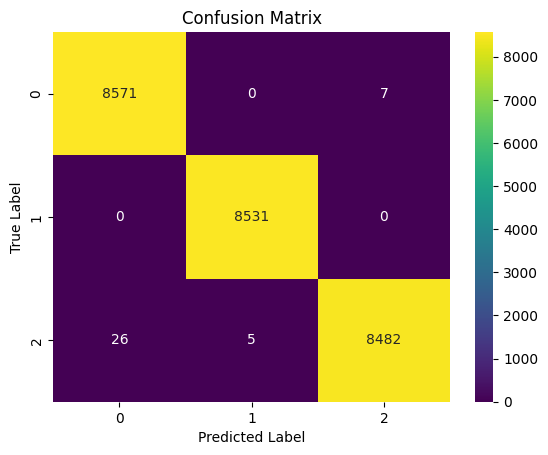

In [42]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [43]:
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[8571    0    7]
 [   0 8531    0]
 [  26    5 8482]]


In [44]:
print("Deep Learning Model Performance:")
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

Deep Learning Model Performance:
[[8571    0    7]
 [   0 8531    0]
 [  26    5 8482]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8578
         1.0       1.00      1.00      1.00      8531
         2.0       1.00      1.00      1.00      8513

    accuracy                           1.00     25622
   macro avg       1.00      1.00      1.00     25622
weighted avg       1.00      1.00      1.00     25622



In [45]:
import json

In [46]:
history_dict = history.history
with open('history.json', 'w') as f:
    json.dump(history_dict, f)

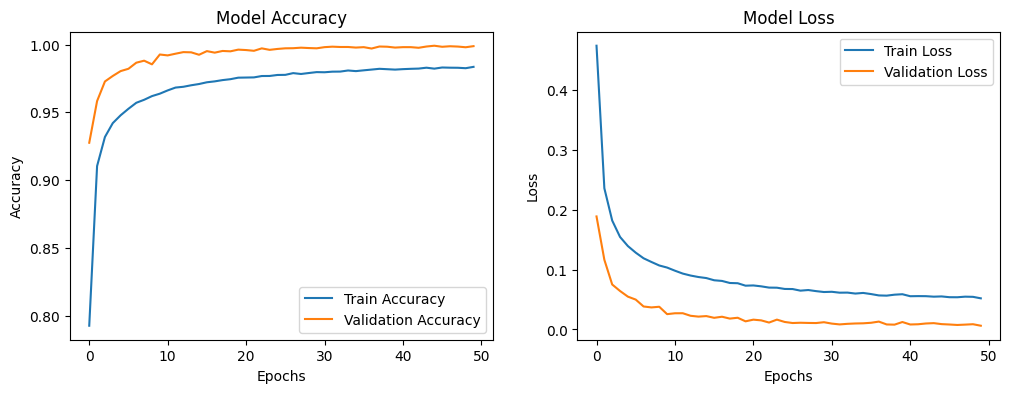

In [47]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()